# **Modelling and Evaluation**

**Objective**
- Answer buisness requirement 2:
The client is interested in predicting if a cherry tree is healthy or contains powdery mildew.

**Inputs**
- inputs/cherry_leaves_dataset/cherry-leaves/test
- inputs/cherry_leaves_dataset/cherry-leaves/train
- inputs/cherry_leaves_dataset/cherry-leaves/validation
- image shaper embeddings.

**Outputs**
- Image distribution plot for train, validation and test.
- Image augmentation.
- Class indices to change prediction inference in labels.
- ML learning model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model evaluation on pickle file. 
- Prediction on the random image file.
<br>

## **Import Packages**

In [20]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib
from matplotlib.image import imread

## **Set working directory**

In [3]:
cwd = os.getcwd()

In [4]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

## **Set input directories**


In [6]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## **Set output directory**


In [7]:
version = 'v1'
file_path = os.path.join(work_dir, 'outputs', version)
if 'outputs' in os.listdir(work_dir) and version in os.listdir(os.path.join(work_dir, 'outputs')):
    print('Old verison is already available create a new verison')
else:
    os.makedirs(name=file_path)
    print(f"Create new directory at {file_path}")

Old verison is already available create a new verison


## **Set labels**

In [8]:
labels = os.listdir(train_path)
print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


## **Set image shape**


In [9]:
import joblib 
verison = 'v1'
image_shape =  joblib.load(filename=os.path.join('outputs', verison, 'image_shape.pk1'))
image_shape

(256, 256, 3)

<br>

## **Number of images in train, test and validation data**


* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


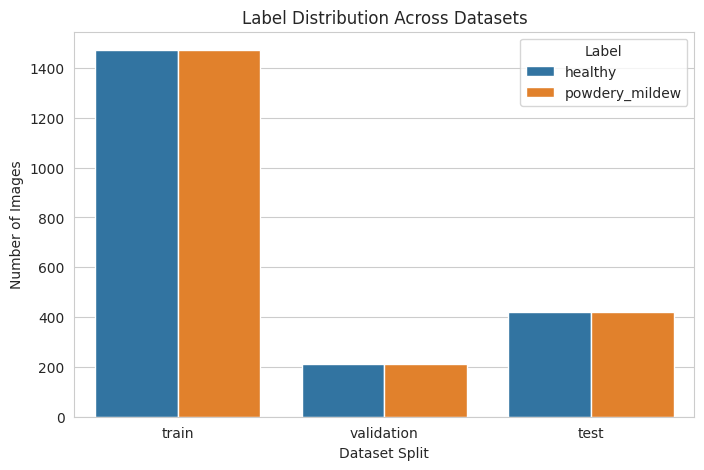

In [10]:
data = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        label_path = os.path.join(my_data_dir, folder, label)
        frequency = len(os.listdir(label_path))
        data.append({'Set' : folder, 'Label' : label, 'Frequency' : frequency})
        print(f"* {folder} - {label}: {frequency} images")
        
df_freq = pd.DataFrame(data)

# plotting
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y= 'Frequency', hue='Label')
plt.title('Label Distribution Across Datasets')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')

# save plot
plt.savefig(f"{file_path}/labels_distribution.png", bbox_inches='tight',dpi=150)
plt.show()

## **Image data augmentation**

**ImageDataGenerator**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Initialize ImageDataGenerator**

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

**Augment train image dataset**

In [13]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True
                                                    )
train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Augment validation image dataset**

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Augment test image dataset**

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                target_size=image_shape[:2],
                                                                color_mode='rgb',
                                                                batch_size=batch_size,
                                                                class_mode='binary',
                                                                shuffle=False
                                                                )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Plot augmented training image**


(20, 256, 256, 3)


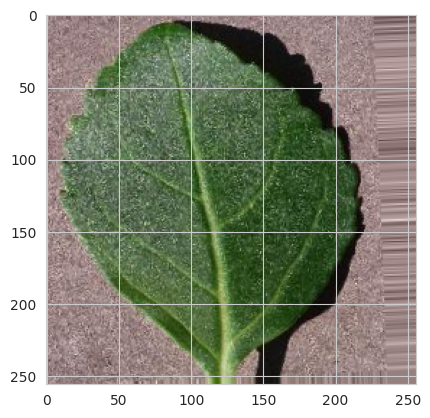

(20, 256, 256, 3)


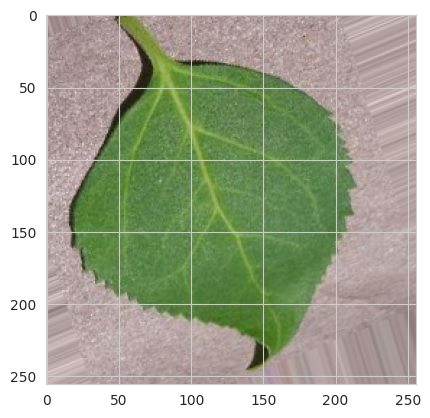

(20, 256, 256, 3)


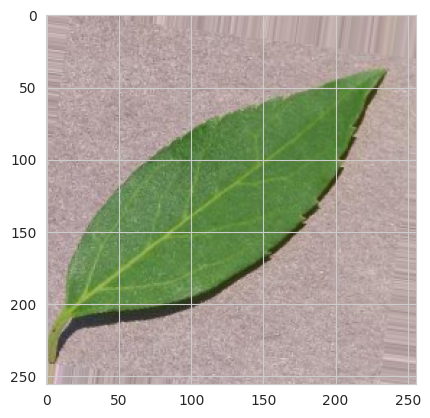

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

**Plot augmented validation images**

(20, 256, 256, 3)


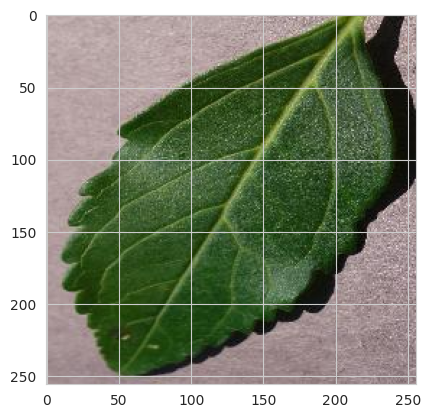

(20, 256, 256, 3)


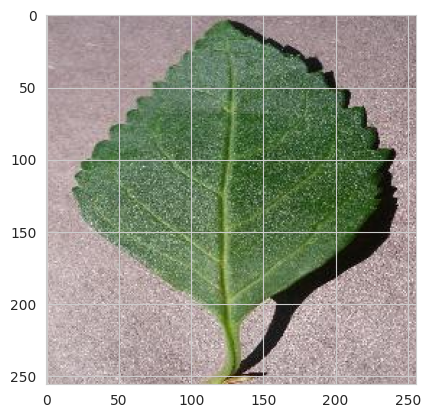

(20, 256, 256, 3)


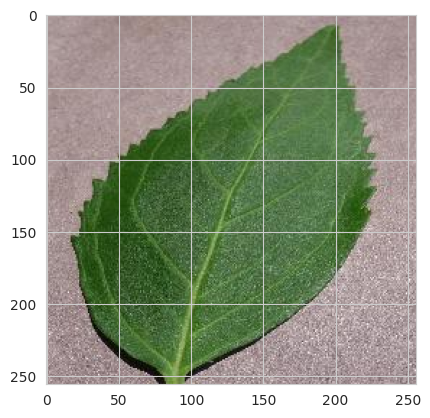

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

**Plot augmented test images**

(20, 256, 256, 3)


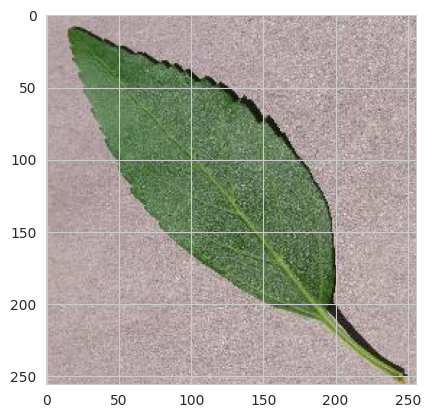

(20, 256, 256, 3)


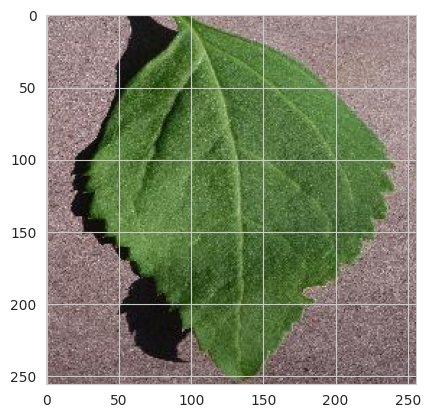

(20, 256, 256, 3)


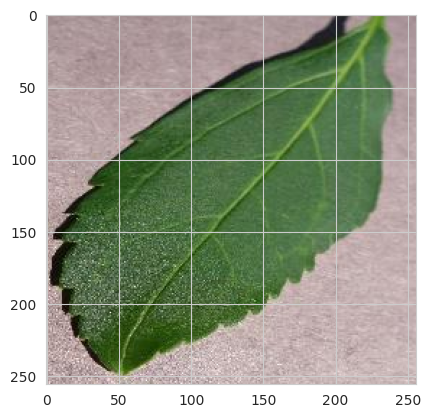

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

**Save class indices**

In [22]:
os.makedirs(file_path, exist_ok=True)
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pk1")

['/workspace/mildew-detector/outputs/v1/class_indices.pk1']

## **Model Creation**


**ML model**
- import packages

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

**Model**

In [59]:
def create_tf_model():
    model = Sequential()
    #First convolutional block
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    #second convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    #third  convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                     input_shape=image_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    #flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),  
        metrics=['accuracy'])
    
    return model

In [60]:
create_tf_model().summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_51 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_52 (Batc (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 62, 62, 64)      

**Fit model for training**


In [62]:
model = create_tf_model()
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=10,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_steps=len(validation_set),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
147/147 [==============================] - 486s 3s/step - loss: 0.5137 - accuracy: 0.9388 - val_loss: 26.8678 - val_accuracy: 0.5000
Epoch 2/10
147/147 [==============================] - 477s 3s/step - loss: 0.1538 - accuracy: 0.9767 - val_loss: 38.4167 - val_accuracy: 0.5000
Epoch 3/10
147/147 [==============================] - 471s 3s/step - loss: 0.0955 - accuracy: 0.9826 - val_loss: 24.0908 - val_accuracy: 0.5024
Epoch 4/10
147/147 [==============================] - 469s 3s/step - loss: 0.0507 - accuracy: 0.9894 - val_loss: 4.7488 - val_accuracy: 0.7619
Epoch 5/10
147/147 [==============================] - 470s 3s/step - loss: 0.0514 - accuracy: 0.9880 - val_loss: 0.2345 - val_accuracy: 0.9667
Epoch 6/10
147/147 [==============================] - 470s 3s/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.1390 - val_accuracy: 0.9810
Epoch 7/10
147/147 [==============================] - 469s 3s/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.1224 - val_accuracy: 0.9

In [63]:
model.save('/workspace/mildew-detector/outputs/v1/trained_model.h5')

## **Model Performance**

**Model learning curve**

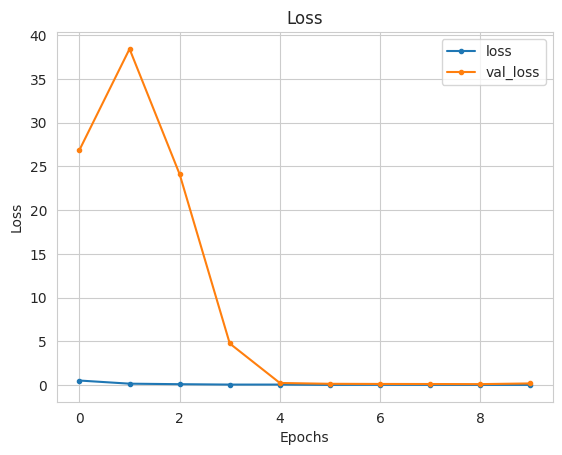

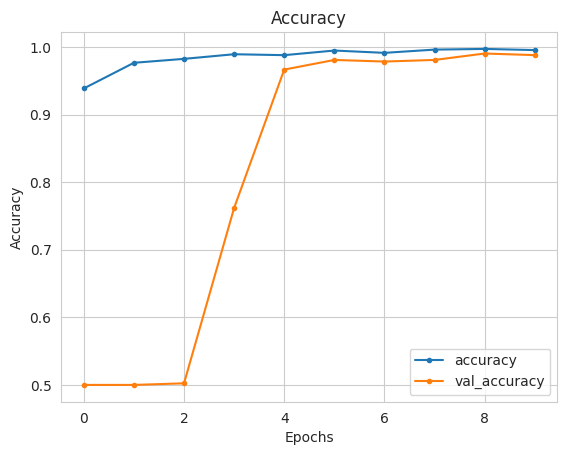

In [64]:
losses = pd.DataFrame(history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(f'{file_path}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

## **Model Evaluation**


**load saved model**

In [65]:
from keras.models import load_model
model = load_model('outputs/v1/trained_model.h5')

**Evaluate model on test set**

In [66]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 29s 650ms/step - loss: 0.2937 - accuracy: 0.9834


## **Save evaluation pickle**

In [67]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pk1")

['outputs/v1/evaluation.pk1']

## **Predict on new data**
Load a random image as PIL

In [71]:
print("Test path:", test_path)
print("Label:", label)
print("Labels:", labels)
print("Image shape:", image_shape)

Test path: inputs/cherry_leaves_dataset/cherry-leaves/test
Label: 0.0
Labels: [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Image shape: (256, 256, 3)


Image shape: (256, 256), Image mode: RGB


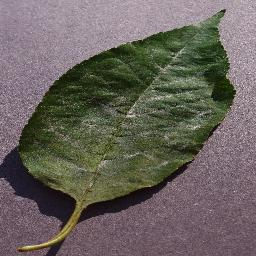

In [75]:
from tensorflow.keras.preprocessing import image

labels = ["healthy", "powdery_mildew"]
test_path = "inputs/cherry_leaves_dataset/cherry-leaves/test"

pointer = 66
label = labels[1]

pil_image = image.load_img(
    os.path.join(test_path, label, os.listdir(os.path.join(test_path, label))[pointer]),
    target_size=image_shape[:2],
    color_mode='rgb'
)

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')

pil_image

Convert image to array for prediction

In [76]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


predict class probabilities

In [77]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}

pred_class_index = int(pred_proba > 0.5)
pred_class = target_map[pred_class_index]

if pred_class_index == 0:
    pred_proba = 1 - pred_proba
    

print("Predicted Probability:", pred_proba)
print("Predicted Class:", pred_class)

Predicted Probability: 0.9999993
Predicted Class: powdery_mildew
